# Cuda matrix multiplication benchmarks

In [23]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = 16, 8

In [24]:
import numpy as np
from numba import cuda
import numba
from timeit import default_timer as timer
from numba import float32

bpg = 32
tpb = 32

res = []

for i in range(1, 12):

    n = bpg * tpb * i

    shared_mem_size = (tpb, tpb)
    griddim = bpg, bpg
    blockdim = tpb, tpb

    @numba.cuda.jit("void(float32[:,:], float32[:,:], float32[:,:])")
    def naive_matrix_mult(A, B, C):
        x, y = cuda.grid(2)
        if x >= n or y >= n:
            return

        C[y, x] = 0
        for i in range(n):
            C[y, x] += A[y, i] * B[i, x]


    @numba.cuda.jit("void(float32[:,:], float32[:,:], float32[:,:])")
    def optimized_matrix_mult(A, B, C):

        # Declare shared memory
        sA = cuda.shared.array(shape=shared_mem_size, dtype=float32)
        sB = cuda.shared.array(shape=shared_mem_size, dtype=float32)

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y
        x, y = cuda.grid(2)

        acc = 0
        for i in range(bpg):
            if x < n and y < n:
                # Prefill cache
                sA[ty, tx] = A[y, tx + i * tpb]
                sB[ty, tx] = B[ty + i * tpb, x]

            # Synchronize all threads in the block
            cuda.syncthreads()

            if x < n and y < n:
                # Compute product
                for j in range(tpb):
                    acc += sA[ty, j] * sB[j, tx]

            # Wait until all threads finish the computation
            cuda.syncthreads()

        if x < n and y < n:
            C[y, x] = acc


    # Prepare data on the CPU
    A = np.array(np.random.random((n, n)), dtype=np.float32)
    B = np.array(np.random.random((n, n)), dtype=np.float32)

    print("(%d x %d) x (%d x %d)" % (n, n, n, n))

    # Prepare data on the GPU
    dA = cuda.to_device(A)
    dB = cuda.to_device(B)
    dC = cuda.device_array_like(A)

    # Time the unoptimized version
    s = timer()
    naive_matrix_mult[griddim, blockdim](dA, dB, dC)
    numba.cuda.synchronize()
    e = timer()
    unopt_ans = dC.copy_to_host()
    tcuda_unopt = e - s

    # Time the optimized version
    s = timer()
    optimized_matrix_mult[griddim, blockdim](dA, dB, dC)
    numba.cuda.synchronize()
    e = timer()
    opt_ans = dC.copy_to_host()
    tcuda_opt = e - s

    print("CUDA without shared memory:", "%.3f" % tcuda_unopt, "s")
    print("CUDA with shared memory   :", "%.3f" % tcuda_opt, "s")

    s = timer()
    np.dot(A,B)
    e = timer()
    npt=e-s
    print("NumPy dot product         :", "%.3f" % npt, "s")
    
    res.append((n, npt, tcuda_opt))

(1024 x 1024) x (1024 x 1024)
CUDA without shared memory: 0.032 s
CUDA with shared memory   : 0.046 s
NumPy dot product         : 0.025 s
(2048 x 2048) x (2048 x 2048)
CUDA without shared memory: 0.063 s
CUDA with shared memory   : 0.044 s
NumPy dot product         : 0.075 s
(3072 x 3072) x (3072 x 3072)
CUDA without shared memory: 0.089 s
CUDA with shared memory   : 0.040 s
NumPy dot product         : 0.299 s
(4096 x 4096) x (4096 x 4096)
CUDA without shared memory: 0.108 s
CUDA with shared memory   : 0.034 s
NumPy dot product         : 0.691 s
(5120 x 5120) x (5120 x 5120)
CUDA without shared memory: 0.131 s
CUDA with shared memory   : 0.034 s
NumPy dot product         : 1.162 s
(6144 x 6144) x (6144 x 6144)
CUDA without shared memory: 0.160 s
CUDA with shared memory   : 0.034 s
NumPy dot product         : 1.969 s
(7168 x 7168) x (7168 x 7168)
CUDA without shared memory: 0.223 s
CUDA with shared memory   : 0.037 s
NumPy dot product         : 2.574 s
(8192 x 8192) x (8192 x 8192)
CUDA

In [25]:
df = pd.DataFrame(res, columns=['n', 'numpy', 'cuda']).set_index('n')
df.T

n,1024,2048,3072,4096,5120,6144,7168,8192,9216,10240,11264
numpy,0.025242,0.075213,0.299228,0.691480,1.162228,1.969397,2.573967,4.518021,5.159562,7.501283,9.963656
cuda,0.045915,0.044266,0.039608,0.033963,0.034011,0.034069,0.036563,0.032611,0.033438,0.032837,0.033399


(0, 10.460576197530838)

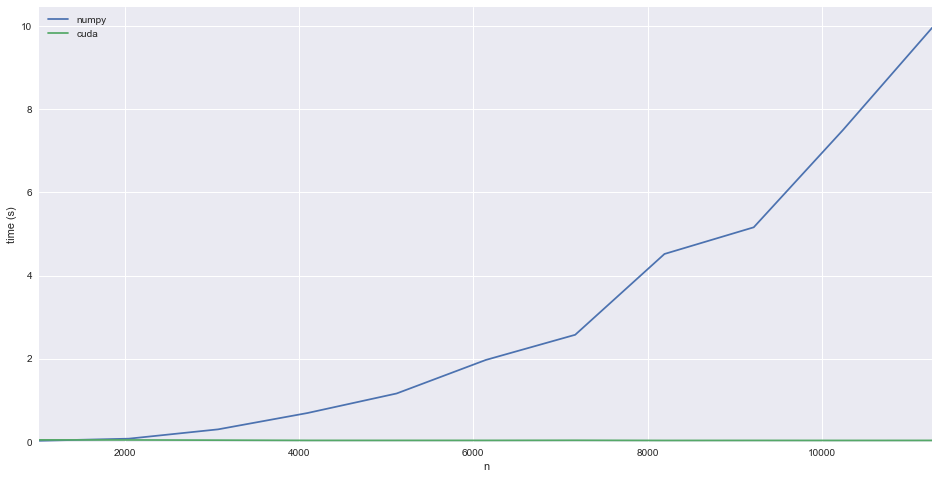

In [26]:
fig, ax = plt.subplots()
df.plot(ax=ax)
plt.ylabel('time (s)')
ax.set_ylim(0)

In [27]:
device = cuda.get_current_device()
print(device)

<CUDA device 0 'b'GeForce GTX 1060''>
